Structure:

- Get images
  - Per patient
  - Train
  - Test
-Run all images through feature detection
-Take each patient, run PCA with k =?
-Run MLP classifier / linear discriminator

# Imports and drive

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime

import re
import json 
import glob

from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA, KernelPCA

# %matplotlib notebook
%matplotlib inline

In [ ]:
# Connect to drive to save work
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Proj_B
!git clone https://github.com/mocedon/VISL_project
!git pull
%cd VISL_project

# Goofing around

In [26]:
t = lambda x: x==5
t(6)

False

In [22]:
d = [{"t":"ts" , "m":"msi", "im":0},
     {"t":"ts" , "m":"mss", "im":1},
     {"t":"ts" , "m":"mss", "im":2},
     {"t":"ts" , "m":"msi", "im":3},
     {"t":"ts" , "m":"mss", "im":4},
     {"t":"ts" , "m":"mss", "im":5},
     {"t":"tr" , "m":"msi", "im":6},
     {"t":"tr" , "m":"msi", "im":7},
     {"t":"tr" , "m":"mss", "im":8},
     {"t":"tr" , "m":"mss", "im":9}]
p = pd.DataFrame(d)
p[(p["t"]== 'ts')&(p["m"]=='msi')]

,t,m,im
0,ts,msi,0
3,ts,msi,3


# Fake data

In [ ]:
def fake_data(dir = './data', ptns=12, pchs=10):
  imgs = torch.rand((ptns, pchs,3, 224,224))
  os.mkdir(dir)
  classes = []
  for p in range(ptns):
    case = 'A' if torch.randn(1) > 0 else 'B'
    classes.append(case)
    p_name = "ptn-{}-{}".format(str(p).zfill(3), case)
    pth = os.path.join(dir, p_name)
    os.mkdir(pth)
    for i in range(pchs):
      im = imgs[int(p),i]
      if case is 'B':
        im = im / 2
      fname = os.path.join(dir ,p_name, str(i).zfill(3) + '.png')
      torchvision.utils.save_image(im, fname)
  return classes

In [ ]:
!rm -fr data*
!rm -fr aug_data*
!ls

sample_data


In [ ]:
dir = './data'
classes = fake_data(dir)
!ls

data  sample_data


In [ ]:
def batch_PCA_(imgs ,k=16):
  print("batch input size: {}".format(imgs.shape))
  ret = imgs.mean(dim=0)
  print("batch new size: {}".format(ret.shape))
  return ret

# Util Functions

In [ ]:
def ds_img(imgs):
  s = imgs.shape[-1] // 8
  t = transforms.RandomCrop(s)
  return t(imgs)


In [2]:
def get_device():
  dev = "cuda:0" if torch.cuda.is_available() else "cpu"
  device = torch.device(dev)
  return device


# Data manipulation

In [ ]:
class PatchDataset():
  def __init__(self, dir, parse_fn):
    self.patch_list = []
    for fn in glob.glob(dir + "/**/*.png"):
      self.patch_list.append(parse_fn(fn))
  
  def per_patch(self, h, f, g):
    return h([f(p) for p in self.patch_list if g(p)])

  def get_set(self, t):
    i = lambda x: x
    return self.per_patch(i, i, lambda p: p['set'] == t)
  
  def get_label(self, l):
    i = lambda x: x
    return self.per_patch(i, i, lambda p: p['label'] == l)

  def get_patient(self, c):
    i = lambda x: x
    return self.per_patch(i, i, lambda p: p['patient'] == c)
  


  


In [ ]:
class MssMsiPatchesDataset(Dataset):
    def __init__(self, MSI_dir, MSS_dir, transform=None):
        path_json_file = os.path.join(MSI_dir, 'data.json')
        with open(path_json_file) as json_file:
            MSI_data = json.load(json_file)
        path_json_file = os.path.join(MSS_dir, 'data.json')
        with open(path_json_file) as json_file:
            MSS_data = json.load(json_file)
        self.MSI_dir = MSI_dir
        self.MSS_dir = MSS_dir
        self.MSI_patches = MSI_data['patches']
        self.MSS_patches = MSS_data['patches']
        self.transform = transform 
        
    def __len__(self):
        return len(self.MSI_patches)+len(self.MSS_patches)
         
    def __getitem__(self, index):
        if index < len(self.MSI_patches):
            img_path = os.path.join(self.MSI_dir, self.MSI_patches[index]['img_name'])+".png"
            y_label = torch.tensor(int(self.MSI_patches[index]['label']))
        else:
            img_path = os.path.join(self.MSS_dir, self.MSS_patches[index-len(self.MSI_patches)]['img_name'])+".png"
            y_label = torch.tensor(int(self.MSS_patches[index-len(self.MSI_patches)]['label']))
        
        image = torchvision.io.read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return (image, y_label)
        
        

In [ ]:
def get_transform(dir):
  default_transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToPILImage(), transforms.ToTensor()])
  dataset = torchvision.datasets.DatasetFolder(root=dir, loader=torchvision.io.read_image, extensions='.png', transform=default_transform)
  clc = []
  for img, lbl in dataset:
    clc.append(img)
  print("clc: [{} , {}]".format(len(clc),clc[0].shape))

  tn = torch.Tensor(len(clc), *clc[0].shape)
  print(tn.shape)
  for i in range(len(clc)):
    tn[i] = clc[i]
  print(tn.shape)
  tn.to(get_device())
  dim = [i for i in range(2, len(tn.shape))]
  print('dim is : {}'.format(dim))
  mean = tn.mean(dim=(0,*dim)).cpu()
  std = tn.std(dim=(0,2,3)).cpu()
  print("mean = {}".format(mean))
  print("std = {}".format(std))

  normal_transform = transforms.Compose([default_transform,
                                         transforms.Normalize(mean=mean, std=std)])
  return normal_transform

In [ ]:
def get_class(ds, dir):
  cls = ds.find_classes(dir)[0]
  ret = []
  for c in cls:
    case = c[-1]
    ret.append(case)
  return ret

In [ ]:
def batch_PCA(imgs, fx, k=8):
  bts = imgs.shape[0]
  print("Batch PCA input size: {}".format(imgs.shape))
  ftrs = fx(imgs).reshape(bts, -1).detach().cpu().numpy()
  #ftr_var = (ftrs.T @ ftrs).cpu().numpy()
  PCA_comp = PCA(k, svd_solver='full').fit(ftrs)
  eig_vec = torch.Tensor(PCA_comp.components_)
  print("Eigen Vector size :{} , with max: {}".format(eig_vec.shape, eig_vec.max()))
  return eig_vec

In [ ]:
def batch_aug(dataset, aug_dir, class_fnc, aug_fnc, fx_fnc):
  classes = class_fnc(dataset, dir)

  data = [[] for i in range(len(dataset.find_classes(dir)[0]))]
  for img, lbl in dataset:
    data[lbl].append(img)
  print("data: [{} , {} , {}]".format(len(data),len(data[0]), data[0][0].shape))

  if not os.path.isdir(aug_dir):
    os.mkdir(aug_dir)
  
  for p, d in enumerate(data):
    tn = torch.Tensor(len(d), *d[0].shape)
    for i in range(len(d)):
      tn[i] = d[i]
    tn.requires_grad_(False).to(get_device())

    rd = aug_fnc(tn, fx_fnc).cpu().numpy()

    curr_dir = os.path.join(aug_dir, classes[p])
    if not os.path.isdir(curr_dir):
      os.mkdir(curr_dir)
    fname = os.path.join(curr_dir , str(p).zfill(3) + '.npy')
    with open(fname, 'wb') as f:
      np.save(f, rd)


def read_mtx(path):
  with open(path, 'rb') as f:
    return np.load(f)

# ML Part

In [ ]:
class AutoEncoder(nn.Module):

  def __init__(self, head, rest):
    super(AutoEncoder, self).__init__()
    self.encode = head
    self.decode = reset
  
  def forward(self, imgs):
    x = self.encode(imgs)
    return self.decode(x)

  def feature_ext(self, imgs):
    return self.encode(imgs)

In [ ]:
class vgg16_features(nn.Module):
  def __init__(self):
    super(vgg16_features, self).__init__()
    self.m = torchvision.models.vgg16(pretrained=True)

  def forward(self, imgs):
    ftrs = self.m.features(imgs)
    return torch.max(ftrs, dim=1).values
    

In [ ]:
class MLPmodel(nn.Module):
  def __init__(self, input):
    super(MLPmodel, self).__init__()
    self.mlp = nn.Sequential(
        nn.Linear(input, input//8),
        nn.ReLU(inplace=True),
        nn.Linear(input//8, 2), 
        nn.Softmax(dim=0))

    
  def forward(self, ev):
    ev_ = ev.view(ev.shape[0], -1)
    return self.mlp(ev_)


class LinearReg(nn.Module):
  def __init__(self, input):
    super(LinearReg, self).__init__()
    self.mlp = nn.Sequential(
        nn.Linear(input, 2, bias=True),
        nn.Softmax())

  def forward(self, ev):
    ev_ = ev.view(ev.shape[0], -1)
    ev_ = self.mlp(ev_)

    return ev_



def calculate_accuracy(model, dataloader, criterion, device):
    """Used on a set model to gain loss and accuracy, does not train"""
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    total_loss = 0
    with torch.no_grad():
        for data in dataloader: # Batch wise check
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # Run the images through the net
            _, predicted = torch.max(outputs.data, 1) # Top  result
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).data.item() / len(dataloader)

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, total_loss


def train(hp):
  
  model = hp["model"].to(get_device())
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr= hp['lr'])
  ds_train, ds_test = hp['dataset']
  ld_train = torch.utils.data.DataLoader(ds_train, batch_size=hp['bts'], shuffle=True)
  ld_test = torch.utils.data.DataLoader(ds_test, batch_size=hp['bts'], shuffle=True)
  device = get_device()

    # training loop
  train_error = []
  test_error = []
  for epoch in range(1, hp['epochs'] + 1):
      model.train()  # put in training mode
      running_loss = 0.0
      epoch_time = time.time()
      for i, data in enumerate(ld_train, 0):
          # get the inputs
          inputs, labels = data
          # send them to device
          inputs = inputs.to(device)
          labels = labels.to(device)

          # forward + backward + optimize
          outputs = model(inputs)  # forward pass
          loss = criterion(outputs, labels)  # calculate the loss
          # always the same 3 steps
          optimizer.zero_grad()  # zero the parameter gradients
          loss.backward()  # backpropagation
          optimizer.step()  # update parameters

          # Add statistics
          train_error.append(loss.data.item())
          running_loss += loss.data.item()

      # Advance in learning rate schedule
      # Normalizing the loss by the total number of train batches
      running_loss /= len(ld_train)

      # Calculate training/test set accuracy of the existing model
      train_accuracy, _= calculate_accuracy(model, ld_train, criterion, device)
      test_accuracy, test_loss = calculate_accuracy(model, ld_test, criterion, device)
      test_error.append(test_loss)
      log = "Epoch: {:2d} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
      #train_error.append(running_loss)
      epoch_time = time.time() - epoch_time
      log += "Epoch Time: {:.2f} secs".format(epoch_time)
      print(log)
    
  print('==> Finished Training ...')

  # Graph test and train loss across iterations
  batches = len(ld_train)
  itr = list(range(hp['epochs'] * batches))
  plt.plot(itr, train_error, 'r--', label='Train batch loss', linewidth=0.5)
  itr = list(range(batches,(hp['epochs'] * len(ld_train)+batches), batches))
  plt.plot(itr, test_error, color='g', label='Test Epoch loss', linewidth= 3)
  plt.title('Loss')
  plt.xlabel('Batch')
  plt.ylim(0, max(train_error))
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # save model
  print('==> Saving model ...')
  state = {
      'net': model.state_dict(),
      'epoch': epoch,
  }
  if not os.path.isdir('checkpoints'):
      os.mkdir('checkpoints')
  torch.save(state, './checkpoints/' + hp['name'] +'.pth')
   

# Run Networks

In [ ]:
def preprocess(dir, dir_new):
  model = vgg16_features()
  model.eval()
  #model.features()
  transform = get_transform(dir)
  dataset = torchvision.datasets.DatasetFolder(root=dir, loader=torchvision.io.read_image, extensions='.png', transform=transform)
  batch_aug(dataset, dir_new, get_class, batch_PCA, model)

def process(dir_train, dir_test , model, name):
  transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
  dataset = []
  dataset.append(torchvision.datasets.DatasetFolder(root=dir_train, loader=read_mtx, extensions='.npy', transform=transform))
  dataset.append(torchvision.datasets.DatasetFolder(root=dir_test, loader=read_mtx, extensions='.npy', transform=transform))

  hyper_parameters = {
      'model': model,
      'lr': 1e-3,
      'bts': 2,
      'dataset': dataset,
      'epochs': 12,
      'name': name
  }
  train(hyper_parameters)




In [ ]:
dir = './data'
aug_dir= './aug_data'
preprocess(dir, aug_dir)


clc: [120 , torch.Size([3, 224, 224])]
torch.Size([120, 3, 224, 224])
torch.Size([120, 3, 224, 224])
dim is : [2, 3]
mean = tensor([0.1292, 0.1293, 0.1292])
std = tensor([0.2410, 0.2412, 0.2410])
data: [12 , 10 , torch.Size([3, 224, 224])]
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 49]) , with max: 0.5253630876541138
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 49]) , with max: 0.4803100526332855
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 49]) , with max: 0.5639657378196716
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 49]) , with max: 0.5459295511245728
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 49]) , with max: 0.4696272015571594
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 49]) , with max: 0.49019473791122437
Batch PCA input size: torch

Epoch:  1 | Loss: 0.6921 | Training accuracy: 75.000% | Test accuracy: 75.000% | Epoch Time: 0.04 secs
Epoch:  2 | Loss: 0.6892 | Training accuracy: 91.667% | Test accuracy: 75.000% | Epoch Time: 0.03 secs
Epoch:  3 | Loss: 0.6736 | Training accuracy: 75.000% | Test accuracy: 75.000% | Epoch Time: 0.03 secs
Epoch:  4 | Loss: 0.6707 | Training accuracy: 75.000% | Test accuracy: 75.000% | Epoch Time: 0.03 secs
Epoch:  5 | Loss: 0.6818 | Training accuracy: 58.333% | Test accuracy: 75.000% | Epoch Time: 0.03 secs
Epoch:  6 | Loss: 0.6482 | Training accuracy: 75.000% | Test accuracy: 75.000% | Epoch Time: 0.03 secs
Epoch:  7 | Loss: 0.6521 | Training accuracy: 75.000% | Test accuracy: 91.667% | Epoch Time: 0.03 secs
Epoch:  8 | Loss: 0.6373 | Training accuracy: 91.667% | Test accuracy: 75.000% | Epoch Time: 0.04 secs
Epoch:  9 | Loss: 0.6257 | Training accuracy: 75.000% | Test accuracy: 75.000% | Epoch Time: 0.03 secs
Epoch: 10 | Loss: 0.6690 | Training accuracy: 75.000% | Test accuracy: 75

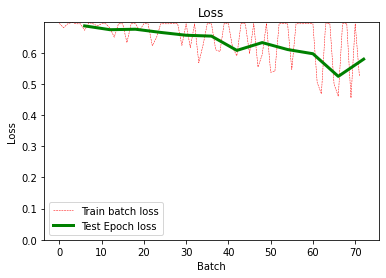

==> Saving model ...
Epoch:  1 | Loss: 0.6884 | Training accuracy: 83.333% | Test accuracy: 83.333% | Epoch Time: 0.04 secs
Epoch:  2 | Loss: 0.6684 | Training accuracy: 91.667% | Test accuracy: 91.667% | Epoch Time: 0.03 secs
Epoch:  3 | Loss: 0.6509 | Training accuracy: 91.667% | Test accuracy: 91.667% | Epoch Time: 0.03 secs
Epoch:  4 | Loss: 0.6349 | Training accuracy: 91.667% | Test accuracy: 91.667% | Epoch Time: 0.03 secs
Epoch:  5 | Loss: 0.6203 | Training accuracy: 91.667% | Test accuracy: 91.667% | Epoch Time: 0.03 secs


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:  6 | Loss: 0.6055 | Training accuracy: 91.667% | Test accuracy: 91.667% | Epoch Time: 0.04 secs
Epoch:  7 | Loss: 0.5914 | Training accuracy: 100.000% | Test accuracy: 100.000% | Epoch Time: 0.03 secs
Epoch:  8 | Loss: 0.5781 | Training accuracy: 100.000% | Test accuracy: 100.000% | Epoch Time: 0.03 secs
Epoch:  9 | Loss: 0.5655 | Training accuracy: 100.000% | Test accuracy: 100.000% | Epoch Time: 0.03 secs
Epoch: 10 | Loss: 0.5537 | Training accuracy: 100.000% | Test accuracy: 100.000% | Epoch Time: 0.03 secs
Epoch: 11 | Loss: 0.5425 | Training accuracy: 100.000% | Test accuracy: 100.000% | Epoch Time: 0.03 secs
Epoch: 12 | Loss: 0.5317 | Training accuracy: 100.000% | Test accuracy: 100.000% | Epoch Time: 0.03 secs
==> Finished Training ...


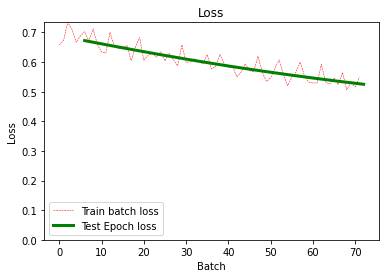

==> Saving model ...


In [ ]:
process(aug_dir, aug_dir, MLPmodel(392), "MLP_test")
process(aug_dir, aug_dir, LinearReg(392), "LR_test")

In [ ]:
class patches_DataSet(torchvision.datasets.DatasetFolder):
  def __init__(root='./data'):
    super(torchvision.datasets.DatasetFolder, seld).init__(root=root, loader=torchvision.io.read_image, extensions='.png')

  def find_classes(dir):
    return None